In [31]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
%run '/content/drive/MyDrive/EE 243/Assignments/Assignment 1/HW1/Problem4/'extract_features.py

Files already downloaded and verified
Files already downloaded and verified
Data saved to vgg16_train_features.h5
Data saved to alexnet_train_features.h5
Features extracted and saved successfully for training data.


<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Now define your setup_data_loaders function
def setup_data_loaders(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
    return train_loader

# Ensure that other parts of your code also correctly reference imported modules


In [ ]:
def get_model(device):
    model = models.vgg16(pretrained=True).to(device)
    return model

In [ ]:
def get_feature_maps(loader, model, device, layers_to_visualize):
    activations = {layer: torch.Tensor() for layer in layers_to_visualize}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    for name, layer in model.features._modules.items():
        if name in layers_to_visualize:
            layer.register_forward_hook(get_activation(name))

    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = model(data)
            break  # Only process one batch

    return {layer: activations[layer] for layer in layers_to_visualize}

In [ ]:
import torch
import matplotlib.pyplot as plt

def get_feature_maps(loader, model, device, layers):
    model.eval()
    activations = {}

    def hook_fn(layer):
        """Create a hook function that will save the output of a specific layer."""
        def hook(model, input, output):
            activations[layer] = output.detach()
        return hook

    hooks = []
    # Attach hooks to the specified layers
    for i, layer in enumerate(model.children()):
        if str(i) in layers:
            hooks.append(layer.register_forward_hook(hook_fn(f'Layer_{i}')))

    # Process a batch of images
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            model(images)
            break  # Process only one batch for visualization

    # Remove hooks after use
    for hook in hooks:
        hook.remove()

    return activations



In [ ]:
def visualize_feature_maps(feature_maps):
    for layer, fmap in feature_maps.items():
        num_feature_maps = fmap.shape[1]  # Number of feature maps in this layer
        fig, axes = plt.subplots(1, min(5, num_feature_maps), figsize=(20, 4))
        for i in range(min(5, num_feature_maps)):
            ax = axes[i]
            # We take the first image in the batch to display
            ax.imshow(fmap[0, i].cpu().numpy(), cmap='viridis')
            ax.axis('off')
        plt.title(f"Feature Maps from {layer}")
        plt.show()



In [ ]:

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Setup transformations and data loaders to match the Python script
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 32  # Consistent with the Python script
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, pin_memory=True)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and modify models
vgg16 = models.vgg16(pretrained=True)
alexnet = models.alexnet(pretrained=True)

def modify_model(model):
    # Remove the last layer (classifier) to get the features
    return torch.nn.Sequential(*(list(model.children())[:-1]))

vgg16 = modify_model(vgg16).to(device)
alexnet = modify_model(alexnet).to(device)


Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


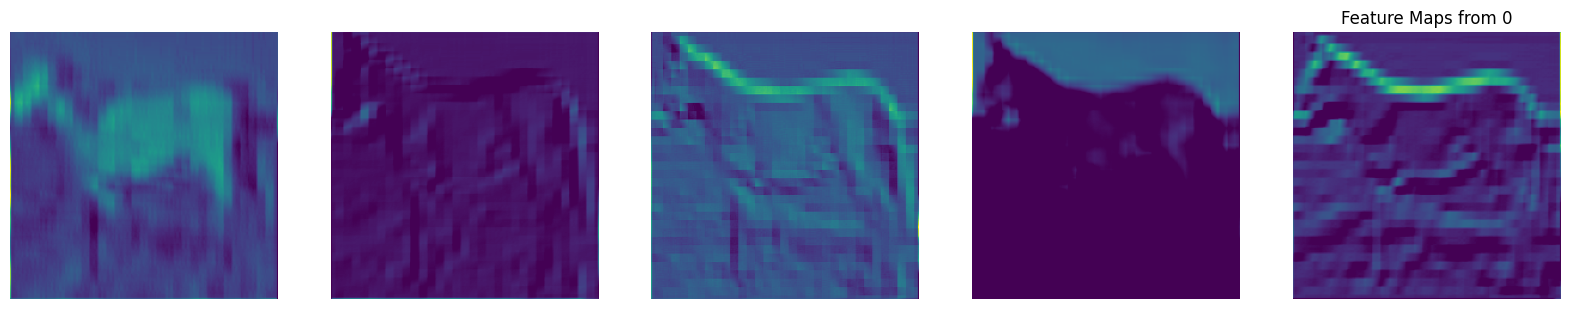

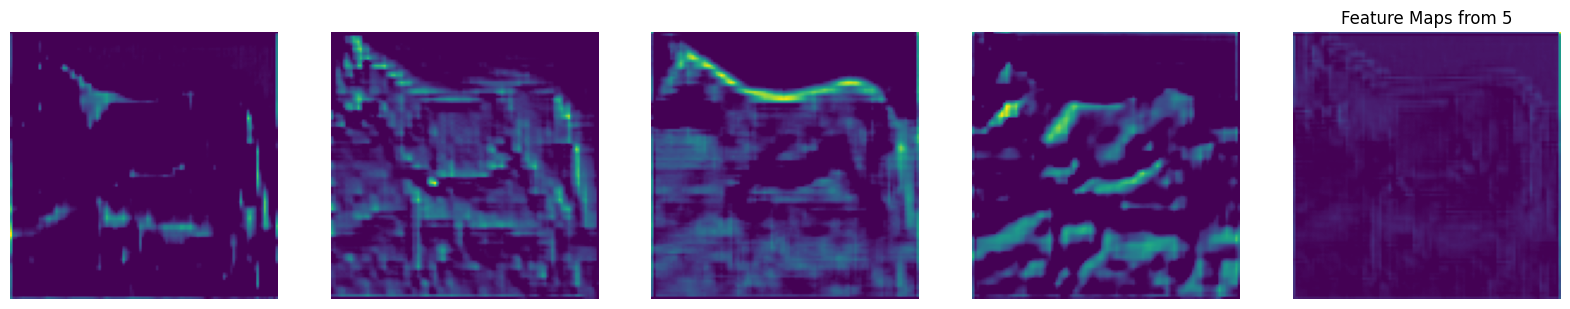

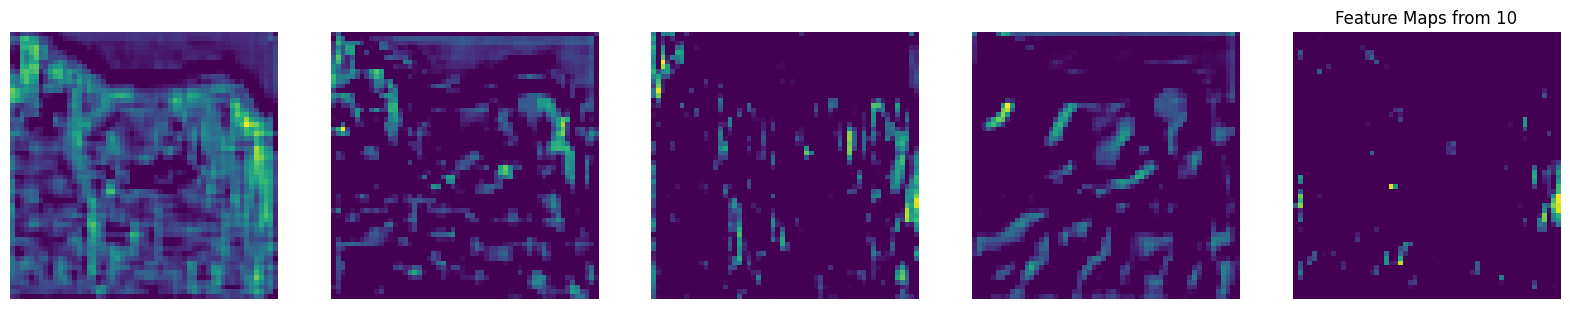

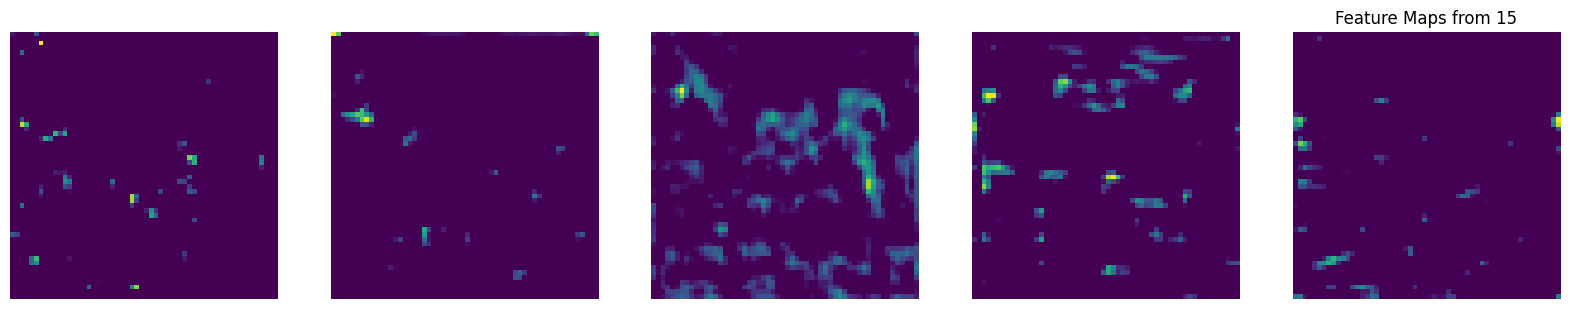

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = setup_data_loaders()
vgg16_extractor = get_model(device)

layers_to_visualize = ['0', '5', '10', '15']  # Adjust to your actual model's layer indices

feature_maps = get_feature_maps(train_loader, vgg16_extractor, device, layers_to_visualize)
visualize_feature_maps(feature_maps)

